In [27]:
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
from datetime import date
from scipy import stats


In [28]:
url = "https://en.wikipedia.org/wiki/List_of_countries_by_level_of_military_equipment"
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

content = soup.find(id="mw-content-text")
tbody_elements = content.find_all('tbody')
country_data = []

# Loop through each <tbody> to find the relevant rows
for tbody in tbody_elements:
    rows = tbody.find_all('tr')
    
    for row in rows:
        # Extract the first column which contains the country name
        country_name_cell = row.find('a')
        if country_name_cell:
            country_name = country_name_cell.text.strip()
            
            # Extract the numerical data from the remaining <td> elements
            data_cells = row.find_all('td')[1:]  # Skip the first <td> (country name)
            row_data = [td.text.strip() for td in data_cells if td.text.strip() != ""]
            
            # Append the country name and data as a list
            if row_data:
                country_data.append([country_name] + row_data)

# Remove the first 3 faulty arrays
if len(country_data) > 3:
    country_data = country_data[3:]

# Step 3: Fix the issue with the 3rd element containing a dot '.'
for entry in country_data:
    if len(entry) > 2 and '.' in entry[2]:
        # Combine the 2nd and 3rd elements into a float
        entry[1] = str(float(entry[1] + entry[2]))
        # Remove the 3rd element
        entry.pop(2)

# Remove all table data that isnt the military capabilities of the 171 countries
country_data = country_data[:171]

# remove all citations
for entry in country_data:
    if entry[2] == '[j]':
        entry.pop(2)

print(country_data[-8])

['United States', '877', '4645', '11', '42', '12', '75', '23', '0', '68', '0', '3368', '867', '5244', '141', '[7][15][16]']


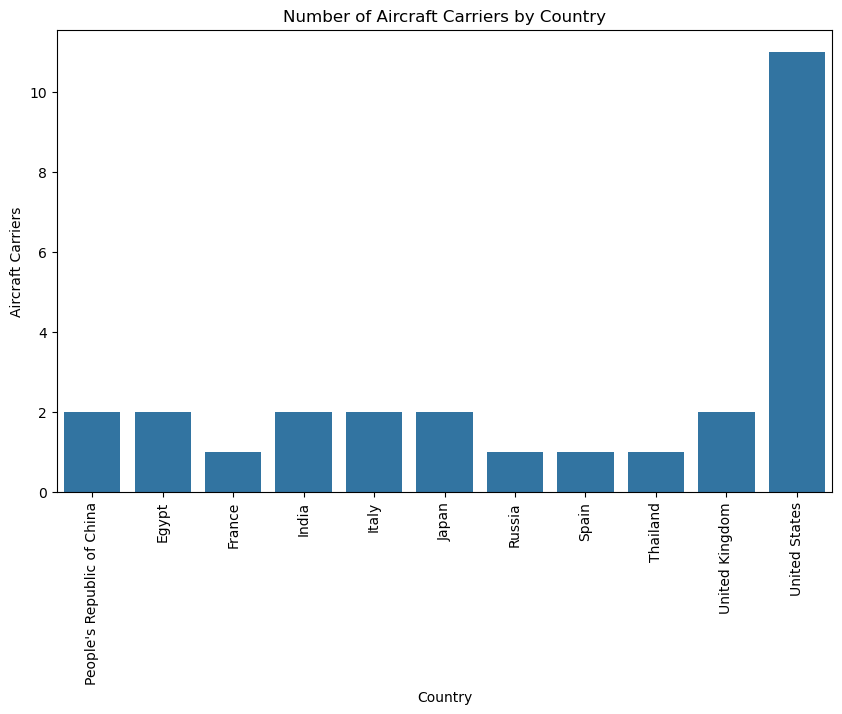

In [29]:
# Filter out countries with zero aircraft carriers (4th element)
countries = []
aircraft_carriers = []

for entry in country_data:
    if len(entry) > 3 and entry[3].isdigit() and int(entry[3]) > 0:
        countries.append(entry[0])
        aircraft_carriers.append(int(entry[3]))

# Step 5: Create a DataFrame
df = pd.DataFrame({
    'Country': countries,
    'Aircraft Carriers': aircraft_carriers
})

# Step 6: Plot the bar chart using Seaborn
plt.figure(figsize=(10,6))
sns.barplot(x='Country', y='Aircraft Carriers', data=df)
plt.xticks(rotation=90)  # Rotate country names for better readability
plt.title('Number of Aircraft Carriers by Country')
plt.show()

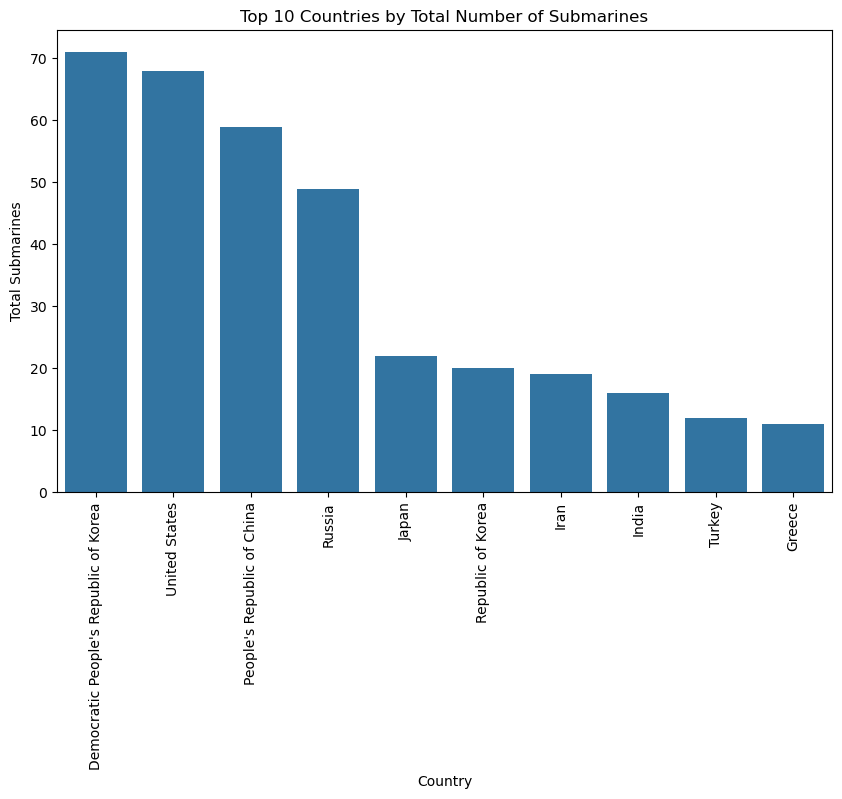

In [30]:
submarine_data = []

for entry in country_data:
    if len(entry) > 10 and entry[9].isdigit() and entry[10].isdigit():
        submarines = int(entry[9]) + int(entry[10])
        if submarines > 0:
            submarine_data.append([entry[0], submarines])

# Step 3: Sort by the total number of submarines and select the top 10
submarine_data_sorted = sorted(submarine_data, key=lambda x: x[1], reverse=True)[:10]

# Step 4: Create a DataFrame for the top 10 countries
df_submarines = pd.DataFrame(submarine_data_sorted, columns=['Country', 'Total Submarines'])

# Step 5: Plot the bar chart using Seaborn
plt.figure(figsize=(10,6))
sns.barplot(x='Country', y='Total Submarines', data=df_submarines)
plt.xticks(rotation=90)  # Rotate country names for better readability
plt.title('Top 10 Countries by Total Number of Submarines')
plt.show()

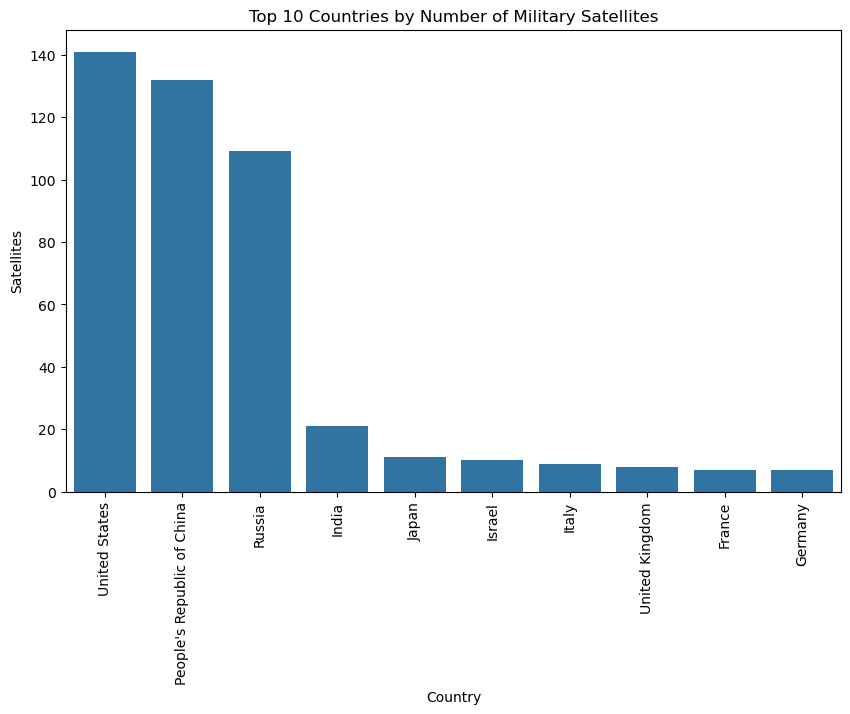

In [31]:
satellite_data = []

for entry in country_data:
    if len(entry) > 14 and entry[14].isdigit() and int(entry[14]) > 0:
        satellites = int(entry[14])
        satellite_data.append([entry[0], satellites])

# Step 3: Sort by the number of satellites and select the top 10 countries
satellite_data_sorted = sorted(satellite_data, key=lambda x: x[1], reverse=True)[:10]

# Step 4: Create a DataFrame for the top 10 countries
df_satellites = pd.DataFrame(satellite_data_sorted, columns=['Country', 'Satellites'])

# Step 5: Plot the bar chart using Seaborn
plt.figure(figsize=(10,6))
sns.barplot(x='Country', y='Satellites', data=df_satellites)
plt.xticks(rotation=90)  # Rotate country names for better readability
plt.title('Top 10 Countries by Number of Military Satellites')
plt.show()

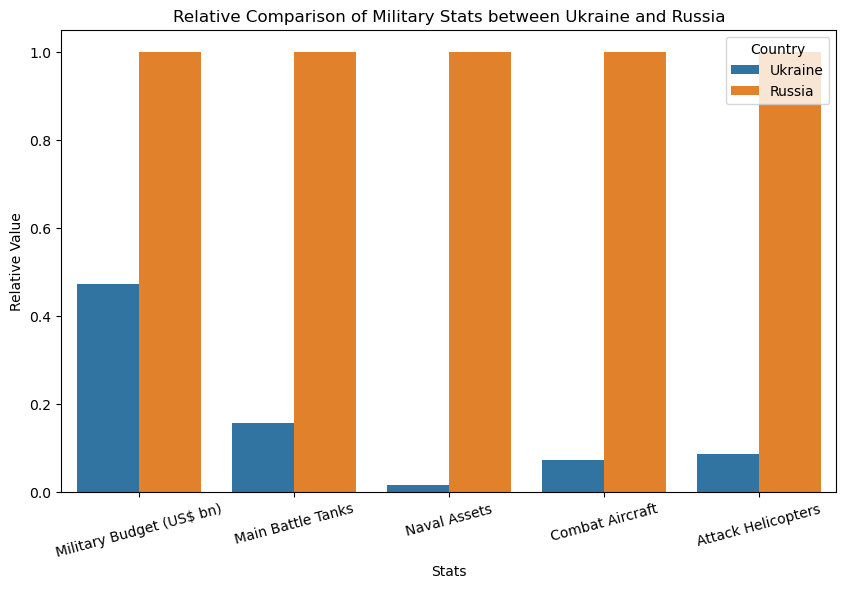

In [32]:
# Step 2: Extract relevant data for Ukraine and Russia
def get_relevant_stats(country_name, country_data):
    for entry in country_data:
        if entry[0] == country_name:
            # Military Budget (element 2)
            military_budget = float(entry[1]) if len(entry) > 1 else 0.0
            
            # Main battle tanks (element 3)
            main_battle_tanks = int(entry[2]) if len(entry) > 2 and entry[2].isdigit() else 0
            
            # Naval Assets (sum of elements 5-11)
            naval_assets = sum(int(entry[i]) for i in range(4, 11) if len(entry) > i and entry[i].isdigit())
            
            # Combat Aircraft (element 12)
            combat_aircraft = int(entry[11]) if len(entry) > 11 and entry[11].isdigit() else 0
            
            # Attack Helicopters (element 13)
            attack_helicopters = int(entry[12]) if len(entry) > 12 and entry[12].isdigit() else 0
            
            return [military_budget, main_battle_tanks, naval_assets, combat_aircraft, attack_helicopters]

ukraine_stats = get_relevant_stats("Ukraine", country_data)
russia_stats = get_relevant_stats("Russia", country_data)

# Step 3: Normalize the relevant stats
stats_labels = ["Military Budget (US$ bn)", "Main Battle Tanks", "Naval Assets", "Combat Aircraft", "Attack Helicopters"]
normalized_stats = []

for i in range(len(stats_labels)):
    max_value = max(ukraine_stats[i], russia_stats[i])
    if max_value > 0:
        normalized_ukraine = ukraine_stats[i] / max_value
        normalized_russia = russia_stats[i] / max_value
    else:
        normalized_ukraine = normalized_russia = 0
    normalized_stats.append([stats_labels[i], normalized_ukraine, normalized_russia])

# Step 4: Create a DataFrame for normalized stats
df_normalized = pd.DataFrame(normalized_stats, columns=['Stats', 'Ukraine', 'Russia'])

# Step 5: Convert DataFrame for Seaborn
df_normalized_melted = df_normalized.melt(id_vars='Stats', var_name='Country', value_name='Relative Value')

# Step 6: Plot the normalized bar chart
plt.figure(figsize=(10,6))
sns.barplot(x='Stats', y='Relative Value', hue='Country', data=df_normalized_melted)
plt.xticks(rotation=15)
plt.title('Relative Comparison of Military Stats between Ukraine and Russia')
plt.show()

In [33]:
# Sources
russia_url = "https://www.oryxspioenkop.com/2022/02/attack-on-europe-documenting-equipment.html"
ukraine_url = "https://www.oryxspioenkop.com/2022/02/attack-on-europe-documenting-ukrainian.html"

In [34]:
def scrape_data(country):
    if country == "Russia":
        url = russia_url
    else:
        url = ukraine_url

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    materiel = soup.select('article li')

    data = []

    for item in materiel:
        system = item.get_text().split(':')[0].strip()
        origin = item.find('img')['src'].split('/')[-1].replace('Flag_of_the_', '').replace('Flag_of_', '').replace('.png', '').replace('_', ' ')
        
        for status_link in item.find_all('a'):
            status = re.findall(r'destroyed|captured|abandoned|damaged', status_link.text.lower())
            if status:
                data.append({
                    'country': country,
                    'origin': origin,
                    'system': system,
                    'status': status[0],
                    'url': status_link['href'],
                    'date_recorded': date.today()
                })

    df = pd.DataFrame(data)
    
    return df

def create_data():
    russia = scrape_data("Russia")
    ukraine = scrape_data("Ukraine")

    data = pd.concat([russia, ukraine]).drop_duplicates()

    return data

In [35]:
def create_by_type(country):
    if country == "Russia":
        url = russia_url
    else:
        url = ukraine_url

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    heads = soup.select('article div h3')

    # Drop the empty cell padding
    heads = [h.text for h in heads if h.text.strip()]

    totals = []
    for head in heads:
        equipment = re.sub(r'\s*\(.*\)', '', head)
        destroyed = re.search(r'destroyed: (\d+)', head)
        abandoned = re.search(r'(abandoned|aboned): (\d+)', head)
        captured = re.search(r'captured: (\d+)', head)
        damaged = re.search(r'damaged: (\d+)', head)

        totals.append({
            'equipment': equipment,
            'destroyed': int(destroyed.group(1)) if destroyed else 0,
            'abandoned': int(abandoned.group(2)) if abandoned else 0,
            'captured': int(captured.group(1)) if captured else 0,
            'damaged': int(damaged.group(1)) if damaged else 0
        })

    df = pd.DataFrame(totals)
    df['country'] = country
    df['type_total'] = df['destroyed'] + df['abandoned'] + df['captured'] + df['damaged']
    
    # Replace the first row's equipment with "All Types"
    df.loc[0, 'equipment'] = "All Types"
    
    df = df.rename(columns={'equipment': 'equipment_type'})
    
    return df

def totals_by_type():
    russia = create_by_type("Russia")
    ukraine = create_by_type("Ukraine")

    totals_df = pd.concat([russia, ukraine], ignore_index=True)
    
    return totals_df

In [36]:
result = create_data()
print(result.head())
# result.to_csv("data/totals_by_system.csv", index=False)

  country                 origin     system     status  \
0  Russia  23px-Soviet Union.svg  2 T-54-3M  destroyed   
1  Russia  23px-Soviet Union.svg  2 T-54-3M    damaged   
2  Russia  23px-Soviet Union.svg    1 T-54B  destroyed   
3  Russia  23px-Soviet Union.svg    3 T-55A  destroyed   
4  Russia  23px-Soviet Union.svg    3 T-55A  destroyed   

                                                 url date_recorded  
0  https://i.postimg.cc/zBC4NPVv/1032-unkn-t55-de...    2024-09-25  
1  https://i.postimg.cc/s29RHpfN/1036-T-54-3-M-da...    2024-09-25  
2  https://i.postimg.cc/02ZtkYNd/1020-T-54-B-dest...    2024-09-25  
3  https://twitter.com/bayraktar_1love/status/175...    2024-09-25  
4  https://i.postimg.cc/rsGYFggv/1009-T-55-A-dest...    2024-09-25  


In [37]:

result = totals_by_type()
print(result.head())
# result.to_csv("data/totals_by_type.csv", index=False)

                                      equipment_type  destroyed  abandoned  \
0                                          All Types      13291       1008   
1  Losses excluding Recon Drones and Trucks - 139...      10100        959   
2  Losses of Armoured Combat Vehicles [Tanks, AFV...       7389        881   
3                                              Tanks       2351        368   
4                         Armoured Fighting Vehicles       1184         97   

   captured  damaged country  type_total  
0      2974      804  Russia       18077  
1      2229      707  Russia       13995  
2      1528      365  Russia       10163  
3       532      157  Russia        3408  
4       271       36  Russia        1588  


In [38]:
# The historical dataset is very large, and took ~12 hours to scrape. So it is saved and loaded from a CSV file.
# tools/scrape.py contains the code to scrape the historical dataset, as well as the script used to compile scraped 
# data into a single CSV file.

df = pd.read_csv('data/combined_totals.csv')

# Clean the leading sum from the beginning of the equipment type
def clean_equipment_type(equipment):
    return re.sub(r'^\d+\s+', '', equipment)

df['equipment_type'] = df['equipment_type'].apply(clean_equipment_type)

# Convert the date to a datetime object
df['date'] = pd.to_datetime(df['date'])

In [39]:
# Get unique equipment types for each country
ukraine_equipment = set(df[df['country'] == 'Ukraine']['equipment_type'])
russia_equipment = set(df[df['country'] == 'Russia']['equipment_type'])

# Find shared equipment
shared_equipment = ukraine_equipment.intersection(russia_equipment)

# Because the dataset already includes the total count of each equipment type, we don't need to sum manually. 
# And can just grab the latest data for each equipment type.
def get_latest_data(equipment_type):
    equipment_data = df[df['equipment_type'] == equipment_type]
    latest_date = equipment_data['date'].max()
    return equipment_data[equipment_data['date'] == latest_date].iloc[0]

# UKR and RU have a lot of shared systems, so lets just look at the heavily utilized systems.
heavily_destroyed_equipment = {}

for equipment in shared_equipment:
    latest_data = get_latest_data(equipment)
    if latest_data['destroyed'] > 100:
        heavily_destroyed_equipment[equipment] = latest_data['destroyed']

for equipment, destroyed_count in sorted(heavily_destroyed_equipment.items(), key=lambda x: x[1], reverse=True):
    print(f"- {equipment}: {destroyed_count} destroyed")

- All Types: 12370.0 destroyed
- BMP-2(K): 916.0 destroyed
- Ural-4320: 767.0 destroyed
- KamAZ 6x6: 756.0 destroyed
- MT-LB: 715.0 destroyed
- BMP-1(P): 563.0 destroyed
- T-80BV: 416.0 destroyed
- Unknown tank: 327.0 destroyed
- T-72B: 236.0 destroyed
- BMD-2: 209.0 destroyed
- Unknown AFV: 196.0 destroyed
- Unknown BMP-1/2: 177.0 destroyed
- 122mm BM-21 Grad: 162.0 destroyed
- 152mm 2S19 Msta-S: 153.0 destroyed
- BTR-80: 150.0 destroyed
- 122mm 2S1 Gvozdika: 112.0 destroyed
- Unknown T-72: 110.0 destroyed
- KamAZ 6x6 tanker: 103.0 destroyed


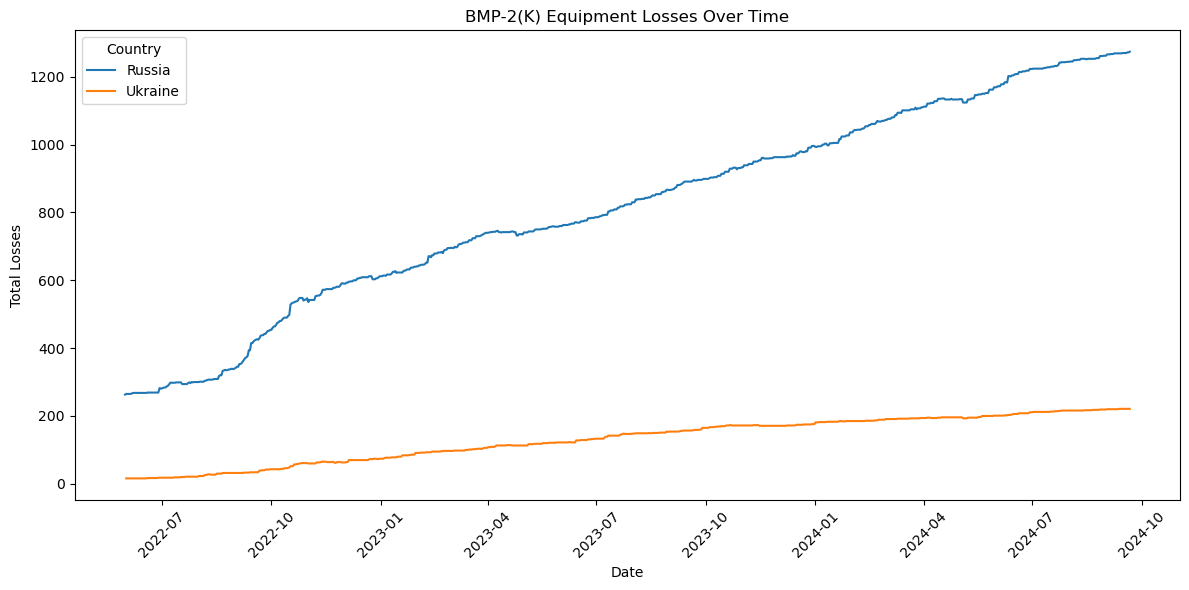

           date  country                 origin equipment_type  destroyed  \
349  2023-05-18   Russia  23px-Soviet Union.svg       BMP-2(K)      475.0   
479  2024-03-07  Ukraine  23px-Soviet Union.svg       BMP-2(K)      152.0   
1083 2023-03-24   Russia  23px-Soviet Union.svg       BMP-2(K)      454.0   
1185 2023-07-13  Ukraine  23px-Soviet Union.svg       BMP-2(K)      109.0   
1750 2024-03-09   Russia  23px-Soviet Union.svg       BMP-2(K)      737.0   

      abandoned  captured  damaged  type_total  
349        27.0     196.0     54.0       752.0  
479         6.0      23.0     10.0       191.0  
1083       25.0     198.0     53.0       730.0  
1185        5.0      23.0      5.0       142.0  
1750       39.0     206.0    105.0      1087.0  


In [40]:
def filter_equipment(df, equipment_pattern):
    return df[df['equipment_type'].str.contains(equipment_pattern, regex=True, na=False)]

equipment_type = 'BMP-2(K)'

pattern = r'^\d*\s*' + re.escape(equipment_type) + r'$'

filtered_df = filter_equipment(df, pattern)

plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='date', y='type_total', hue='country')

plt.title(f'{equipment_type} Equipment Losses Over Time')
plt.xlabel('Date')
plt.ylabel('Total Losses')
plt.xticks(rotation=45)
plt.legend(title='Country')

plt.tight_layout()
plt.savefig(f'plots/{equipment_type}_losses.png')
plt.show()

print(filtered_df.head())

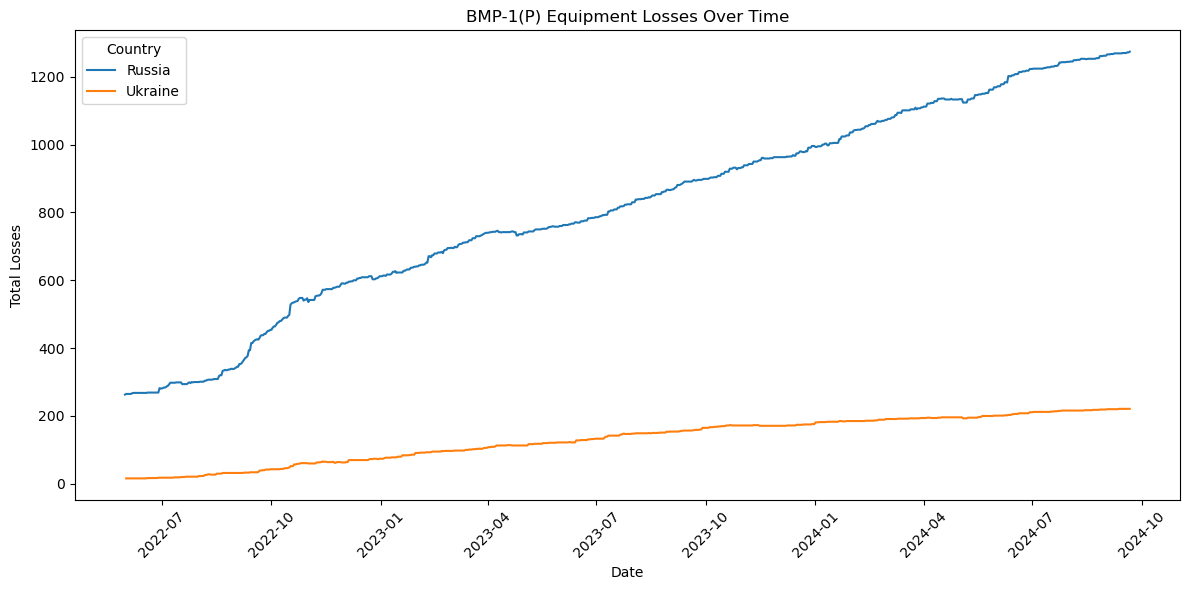

           date  country                 origin equipment_type  destroyed  \
349  2023-05-18   Russia  23px-Soviet Union.svg       BMP-2(K)      475.0   
479  2024-03-07  Ukraine  23px-Soviet Union.svg       BMP-2(K)      152.0   
1083 2023-03-24   Russia  23px-Soviet Union.svg       BMP-2(K)      454.0   
1185 2023-07-13  Ukraine  23px-Soviet Union.svg       BMP-2(K)      109.0   
1750 2024-03-09   Russia  23px-Soviet Union.svg       BMP-2(K)      737.0   

      abandoned  captured  damaged  type_total  
349        27.0     196.0     54.0       752.0  
479         6.0      23.0     10.0       191.0  
1083       25.0     198.0     53.0       730.0  
1185        5.0      23.0      5.0       142.0  
1750       39.0     206.0    105.0      1087.0  


In [41]:
equipment_type = 'BMP-1(P)'

filtered_df = filter_equipment(df, pattern)

plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='date', y='type_total', hue='country')

plt.title(f'{equipment_type} Equipment Losses Over Time')
plt.xlabel('Date')
plt.ylabel('Total Losses')
plt.xticks(rotation=45)
plt.legend(title='Country')

plt.tight_layout()
plt.savefig(f'plots/{equipment_type}_losses.png')
plt.show()

print(filtered_df.head())

In [42]:
# Sourced from IISS Military Balance 2021, we will utilize this as a baseline to examine whether losses for UKR and RU 
# are significantly different.
bmp_stocks_2021  = {
    'Country': ['Ukraine', 'Ukraine', 'Russia', 'Russia'],
    'Vehicle': ['BMP-1(P)', 'BMP-2(K)', 'BMP-1(P)', 'BMP-2(K)'],
    'Count': [213, 890, 450, 2900]
}

bmp_stocks_2021 = pd.DataFrame(bmp_stocks_2021)

In [43]:
# Sourced from Oryx, and filtered from our historical dataset
bmp_data_2024 = {
    'Country': ['Ukraine', 'Ukraine', 'Russia', 'Russia'],
    'Vehicle': ['BMP-2(K)', 'BMP-1(P)', 'BMP-2(K)', 'BMP-1(P)'],
    'Destroyed': [177.0, 315.0, 916.0, 563.0],
    'Captured': [26.0, 47.0, 200.0, 85.0],
    'Abandoned': [6.0, 16.0, 39.0, 22.0],
    'Damaged': [12.0, 25.0, 119.0, 91.0]
}

bmp_data_2024 = pd.DataFrame(bmp_data_2024)
bmp_data_2024['Total Losses'] = bmp_data_2024['Destroyed'] + bmp_data_2024['Captured'] + bmp_data_2024['Abandoned'] + bmp_data_2024['Damaged']

In [44]:
df_merged = pd.merge(bmp_stocks_2021, bmp_data_2024, on=['Country', 'Vehicle'], how='outer')

# Calculate the loss percentage
df_merged['Loss Percentage'] = df_merged['Total Losses'] / df_merged['Count'] * 100
df_merged

,Country,Vehicle,Count,Destroyed,Captured,Abandoned,Damaged,Total Losses,Loss Percentage
0,Russia,BMP-1(P),450,563.0,85.0,22.0,91.0,761.0,169.111111
1,Russia,BMP-2(K),2900,916.0,200.0,39.0,119.0,1274.0,43.931034
2,Ukraine,BMP-1(P),213,315.0,47.0,16.0,25.0,403.0,189.201878
3,Ukraine,BMP-2(K),890,177.0,26.0,6.0,12.0,221.0,24.831461


In [45]:
# Separate data for BMP-1 and BMP-2
bmp1_data = df_merged[df_merged['Vehicle'] == 'BMP-1(P)']['Loss Percentage']
bmp2_data = df_merged[df_merged['Vehicle'] == 'BMP-2(K)']['Loss Percentage']

In [46]:
def perform_ttest(group1, group2, label1, label2):
    t_statistic, p_value = stats.ttest_ind(group1, group2)
    print(f"\nComparison: {label1} vs {label2}")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print(f"The difference in losses between {label1} and {label2} is statistically significant.")
    else:
        print(f"The difference in losses between {label1} and {label2} is not statistically significant.")
    print(f"Mean loss percentage for {label1}: {group1.mean():.2f}%")
    print(f"Mean loss percentage for {label2}: {group2.mean():.2f}%")

# Compare BMP-1(P) vs BMP-2(K)
bmp1p_data = df_merged[df_merged['Vehicle'] == 'BMP-1(P)']['Loss Percentage']
bmp2k_data = df_merged[df_merged['Vehicle'] == 'BMP-2(K)']['Loss Percentage']
perform_ttest(bmp1p_data, bmp2k_data, 'BMP-1(P)', 'BMP-2(K)')

# Compare UKR vs RU
ukraine_data = df_merged[df_merged['Country'] == 'Ukraine']['Loss Percentage']
russia_data = df_merged[df_merged['Country'] == 'Russia']['Loss Percentage']
perform_ttest(ukraine_data, russia_data, 'Ukraine', 'Russia')

print("\nLoss percentages by country and vehicle type:")
for _, row in df_merged.iterrows():
    print(f"{row['Country']} {row['Vehicle']}: {row['Loss Percentage']:.2f}%")


Comparison: BMP-1(P) vs BMP-2(K)
T-statistic: 10.4453118522016
P-value: 0.009041405826271156
The difference in losses between BMP-1(P) and BMP-2(K) is statistically significant.
Mean loss percentage for BMP-1(P): 179.16%
Mean loss percentage for BMP-2(K): 34.38%

Comparison: Ukraine vs Russia
T-statistic: 0.00479741101295102
P-value: 0.9966077376589059
The difference in losses between Ukraine and Russia is not statistically significant.
Mean loss percentage for Ukraine: 107.02%
Mean loss percentage for Russia: 106.52%

Loss percentages by country and vehicle type:
Russia BMP-1(P): 169.11%
Russia BMP-2(K): 43.93%
Ukraine BMP-1(P): 189.20%
Ukraine BMP-2(K): 24.83%
